In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

**Pre-processing**

In [ ]:
INPUT_PATH = "/content/drive/MyDrive/Dataset-IoT/FER-1/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

happy has 600 number of images
sleepy has 600 number of images
surprise has 600 number of images
neutral has 600 number of images


In [ ]:
TOP_EMOTIONS = ["happy", "neutral","sleepy","surprise"]

In [ ]:
INPUT_PATH = "/content/drive/MyDrive/Dataset-IoT/FER-1/"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("-")[0]
            data[dir_][sub].append(f)


In [ ]:
def preprocess_list(x):
    return int((x.split("-")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(10,224,224))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [ ]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

In [ ]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

happy has 60 samples
sleepy has 60 samples
surprise has 60 samples
neutral has 60 samples


In [ ]:
happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

neutral = np.stack(data["neutral"].values(), axis=0)
neutral = neutral.reshape(*neutral.shape,1)

sleepy = np.stack(data["sleepy"].values(), axis=0)
sleepy = sleepy.reshape(*sleepy.shape,1)

surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

X = np.concatenate((happy, neutral, sleepy, surprise))
y = np.concatenate((np.array([0]*60), np.array([1]*60), np.array([2]*60), np.array([3]*60)))

# X = np.concatenate((surprise, happy, anger, sadness, fear, surprise, happy, anger, sadness, fear))
# y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25), np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))

y = np_utils.to_categorical(y)

X.shape, y.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


((240, 10, 224, 224, 1), (240, 4))

In [ ]:
label_emotion_mapper = {0:"happy", 1:"neutral", 2:"sleepy", 3:"surprise"}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((192, 10, 224, 224, 1), (48, 10, 224, 224, 1))

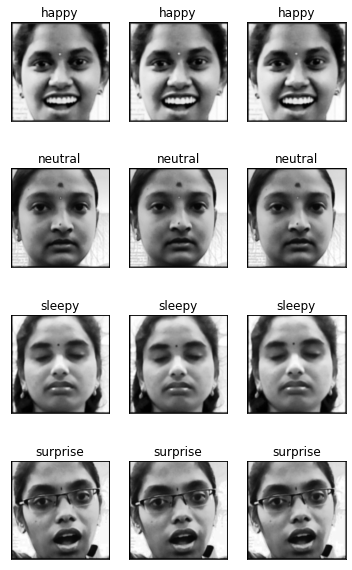

In [ ]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx,]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [ ]:
# data normalization
X_train = X_train / 255.
X_test = X_test / 255.

**CNN+LSTM Model**

In [ ]:
from keras.layers import Input,TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras import Model

inputShape=(10,224,224,1)
input=Input(inputShape)

x=TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),padding='same',activation='elu'),input_shape=(10, 224, 224, 1)) (input)
x=TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(MaxPooling2D(2,2))(x)
x=Dropout(0.3)(x)

x=TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(MaxPooling2D(2,2))(x)
x=TimeDistributed(BatchNormalization())(x)

x=TimeDistributed(Conv2D(256, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(256, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(256, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(256, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(MaxPooling2D(2,2))(x)
x=Dropout(0.3)(x)

x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)

x=TimeDistributed(MaxPooling2D(2,2))(x)
x=TimeDistributed(BatchNormalization())(x)

x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(Conv2D(512, (3, 3), strides=(1,1),activation='elu'))(x)
x=TimeDistributed(MaxPooling2D(2,2))(x)
x=TimeDistributed(BatchNormalization())(x)


x=TimeDistributed(Flatten())(x)
x=Dropout(0.3)(x)

x=LSTM(512,return_sequences=False,dropout=0.2)(x) # used 32 units

x=Dense(128,activation='elu')(x)
x=Dense(64,activation='elu')(x)
x=Dropout(0.3)(x)
x=Dense(4, activation='softmax')(x)

model=Model(inputs=input,outputs=x,name='Pretict')


In [ ]:
model.summary()

Model: "Pretict"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 224, 224, 1)  0         
                             ]                                   
                                                                 
 conv2d_1 (TimeDistributed)  (None, 10, 224, 224, 64)  640       
                                                                 
 time_distributed_38 (TimeDi  (None, 10, 222, 222, 64)  36928    
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 10, 111, 111, 64)  0        
 stributed)                                                      
                                                                 
 dropout_8 (Dropout)         (None, 10, 111, 111, 64)  0         
                                                           

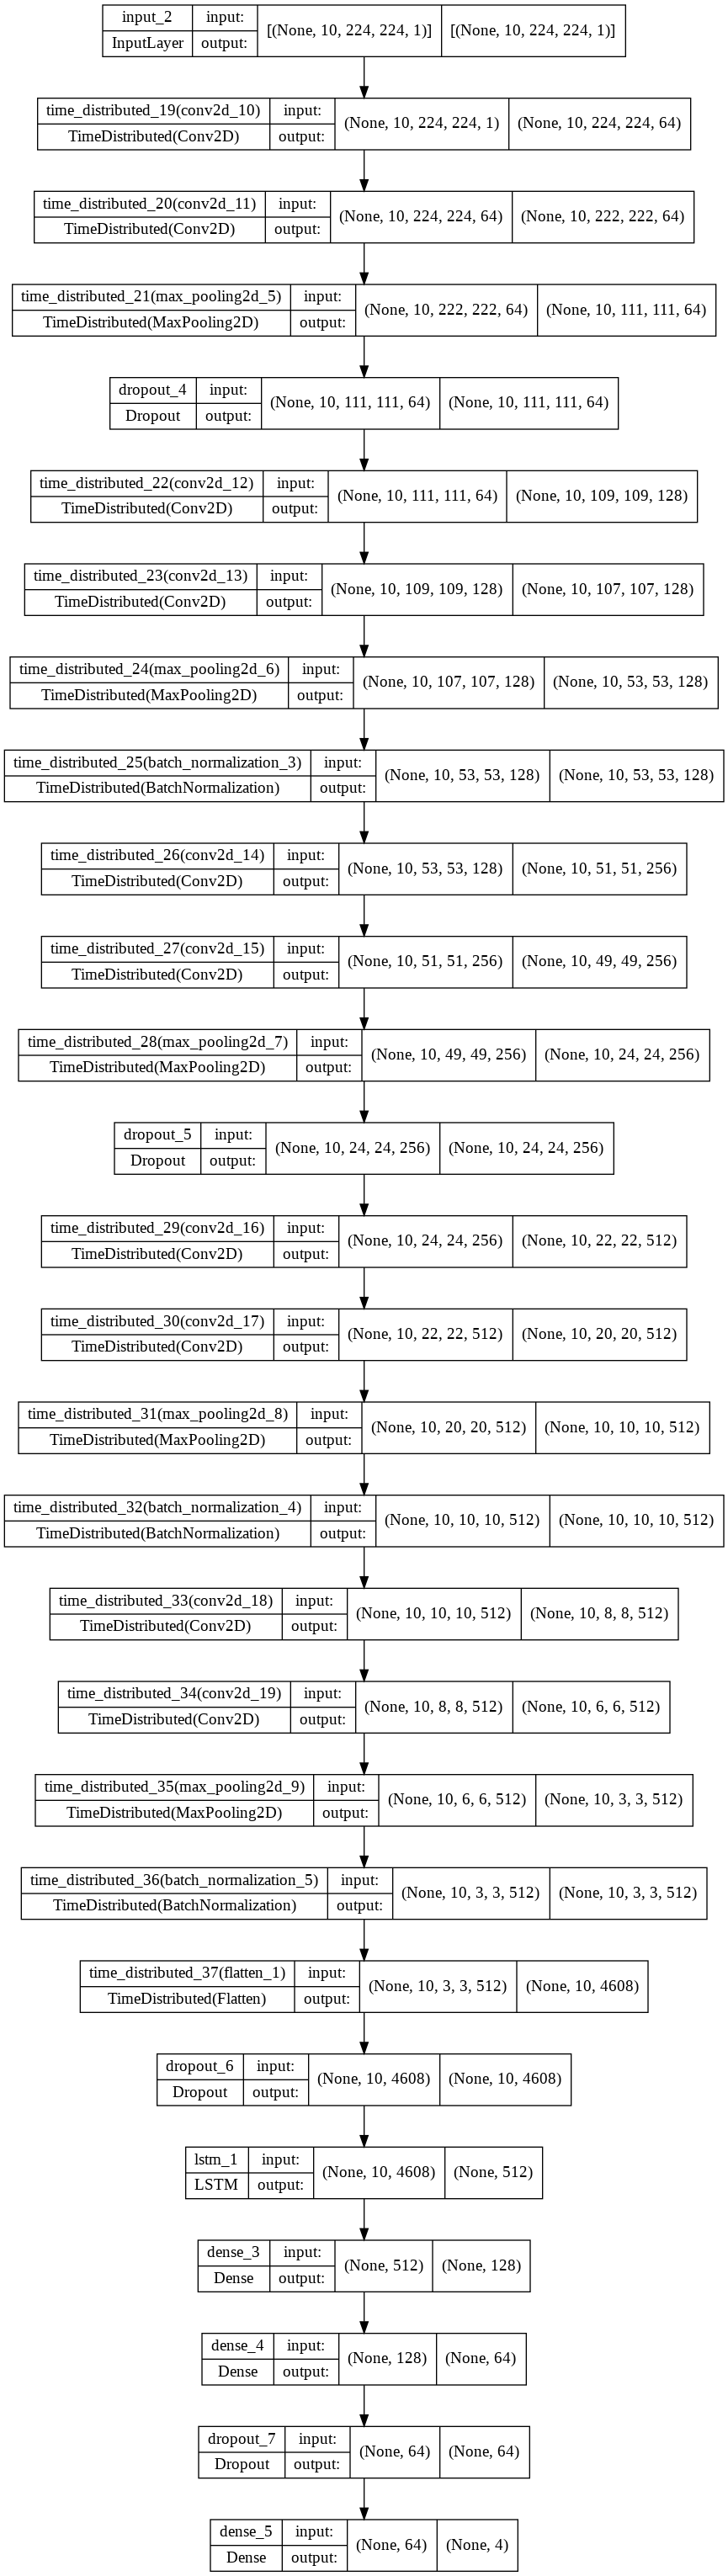

In [ ]:
tf.keras.utils.plot_model(model, to_file='emotion-model.png',show_shapes=True, show_layer_names=True)

In [ ]:
from keras.backend import learning_phase
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# 'cnn_lstm_model_new5.h5'
from tensorflow import keras
from keras import optimizers
callbacks_list_cnlst=[keras.callbacks.EarlyStopping(
monitor='acc',patience=10),
               keras.callbacks.ModelCheckpoint(
               filepath='cnn_lstm_model_new3.h5',
               monitor='val_loss',
               save_best_only=True),
               keras.callbacks.ReduceLROnPlateau(monitor = "val_acc", factor = 0.1, patience = 10, min_lr=1e-7,verbose=1)
               ]
callbacks_list_cnlst = ModelCheckpoint(filepath='cnn_lstm_model_new3.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [callbacks_list_cnlst,early_stopping,lr_scheduler]

from keras import optimizers
optimizer_new=keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_new,loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
history_new_cnlst=model.fit(x=X_train,y=y_train,epochs=70,batch_size=10,
               validation_data=((X_test, y_test)),shuffle = True,
               callbacks=callbacks)

Epoch 1/70
22/22 [==============================] - ETA: 0s - loss: 1.6631 - acc: 0.3194
Epoch 1: val_acc improved from -inf to 0.25000, saving model to cnn_lstm_model_new3.h5
22/22 [==============================] - 80s 2s/step - loss: 1.6631 - acc: 0.3194 - val_loss: 1.6865 - val_acc: 0.2500 - lr: 0.0010
Epoch 2/70
22/22 [==============================] - ETA: 0s - loss: 1.2863 - acc: 0.4259
Epoch 2: val_acc improved from 0.25000 to 0.33333, saving model to cnn_lstm_model_new3.h5
22/22 [==============================] - 29s 1s/step - loss: 1.2863 - acc: 0.4259 - val_loss: 1.4923 - val_acc: 0.3333 - lr: 0.0010
Epoch 3/70
22/22 [==============================] - ETA: 0s - loss: 1.1292 - acc: 0.4676
Epoch 3: val_acc did not improve from 0.33333
22/22 [==============================] - 29s 1s/step - loss: 1.1292 - acc: 0.4676 - val_loss: 1.4002 - val_acc: 0.2500 - lr: 0.0010
Epoch 4/70
22/22 [==============================] - ETA: 0s - loss: 0.9870 - acc: 0.5231
Epoch 4: val_acc improved

In [ ]:
for layer in model.layers:

    if 'conv' not in layer.name:
        continue
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_1 (3, 3, 1, 64)


In [ ]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,224,224,1))

def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

ValueError: ignored

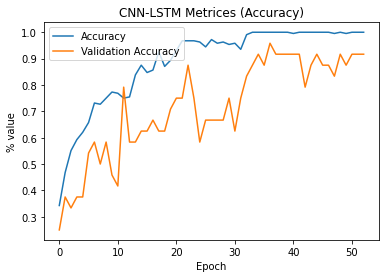

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_new_cnlst.history['acc'], label='Accuracy')
plt.plot(history_new_cnlst.history['val_acc'], label='Validation Accuracy')
plt.title('CNN-LSTM Metrices (Accuracy)')
pyplot.savefig("Accuracy.png")
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

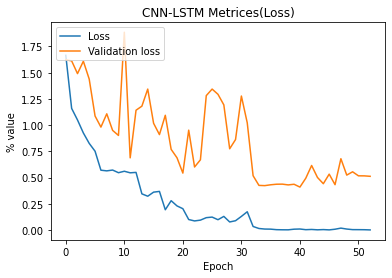

In [ ]:
plt.plot(history_new_cnlst.history['loss'], label='Loss')
plt.plot(history_new_cnlst.history['val_loss'], label='Validation loss')
plt.title('CNN-LSTM Metrices(Loss)')
pyplot.savefig("Loss.png")
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

**Confusion Matrix**

total wrong validation predictions: 2


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      0.83      0.83         6
           2       0.86      1.00      0.92         6
           3       1.00      0.83      0.91         6

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



Text(0.5, 76.01999999999997, 'Predicted')

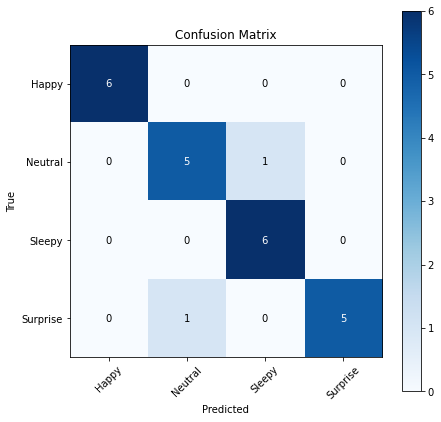

In [ ]:
from matplotlib import pyplot as plt
classNames=["Happy","Neutral","Sleepy","Surprise"]
tick_marks = np.arange(len(classNames))

predict_x=model_cnlst.predict(X_test)
yhat_valid=np.argmax(predict_x,axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.ylabel('True')
plt.xlabel('Predicted')

**Normalized Confusion Matrix**

total wrong validation predictions: 2


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      0.83      0.83         6
           2       0.86      1.00      0.92         6
           3       1.00      0.83      0.91         6

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



Text(0.5, 76.01999999999997, 'Predicted')

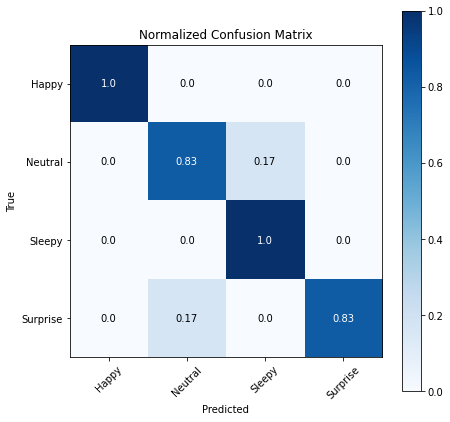

In [ ]:
from matplotlib import pyplot as plt
classNames=["Happy","Neutral","Sleepy","Surprise"]
tick_marks = np.arange(len(classNames))

predict_x=model_cnlst.predict(X_test)
yhat_valid=np.argmax(predict_x,axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, figsize=(7,7),normalize='true')
pyplot.savefig("confusion_matrix 2.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.ylabel('True')
plt.xlabel('Predicted')

**Misclassified Results**

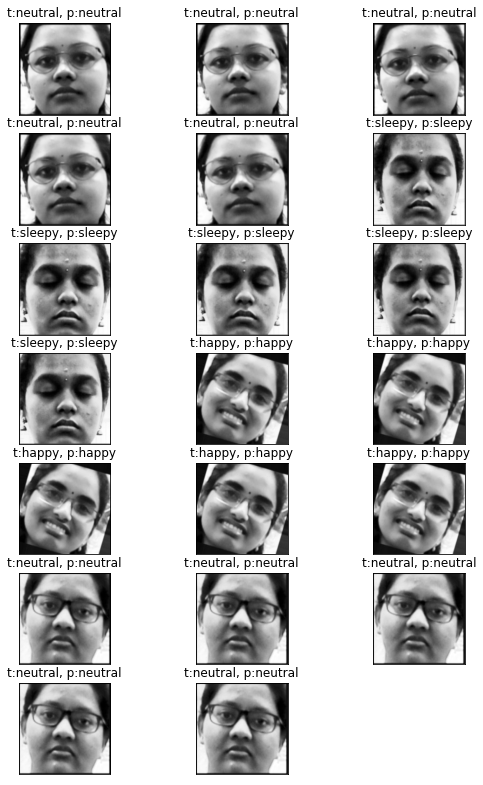

In [ ]:
np.random.seed(0)
indices = np.random.choice(range(X_test.shape[0]), size=4, replace=False)

fig = pyplot.figure(1, (9,30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_test[idx])]
    pred_emotion = label_emotion_mapper[np.argmax(model_cnlst.predict(np.expand_dims(X_test[idx], axis=0))[0])]
    for j in range(3):
        i += 1
        ax = pyplot.subplot(15,3,i)
        sample_img = X_test[idx,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")

**ROC Curve**

In [ ]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle
new_label = ["happy","neutral","sleepy","surprise"]
final_label = new_label
new_class = 4
y_pred = model_cnlst.predict(X_test)
y_pred_ravel = y_pred.ravel()
lw = 2

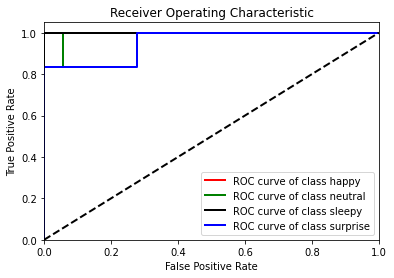

<Figure size 432x288 with 0 Axes>

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
pyplot.savefig("Roc.png")
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
pyplot.savefig("Roc.png")

**Pre-processing**

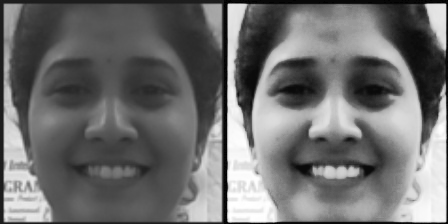

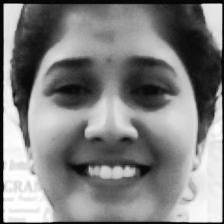

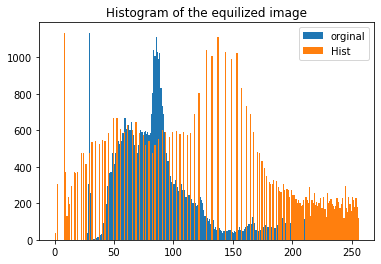

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
img=cv2.imread('/content/C001-001-001.jpg')
img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(img)
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
gray = clahe.apply(img)
res = np.hstack((img,equ))
plt.hist(img.ravel(),256,[0,256])
plt.hist(equ.ravel(),256,[0,256])
#plt.hist(gray.ravel(),256,[0,256])
plt.title('Histogram of the equilized image')
cv2_imshow(res)
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["orginal", "Hist"], loc=0, frameon=legend_drawn_flag)
cv2_imshow(equ)
cv2.waitKey(0)
cv2.destroyAllWindows()

Text(0.5, 1.0, 'Histogram of Oriented Gradients')

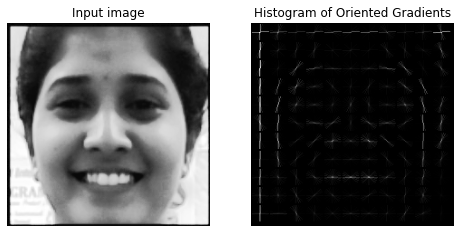

In [ ]:
# import the necessary packages
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

%matplotlib inline
# Dalal and Triggs report that using either 2 x 2 or 3 x 3  cells_per_block  obtains reasonable accuracy in most cases.
file  = "/content/download (10).png"

image = plt.imread(file)

fd, hog_image = hog(image, orientations=15, pixels_per_cell=(20, 20),
                    cells_per_block=(2, 2), visualize=True, block_norm="L1", transform_sqrt=False)
# display the image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
# display the HOG features
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

Text(0.5, 1.0, 'Histogram of Oriented Gradients')

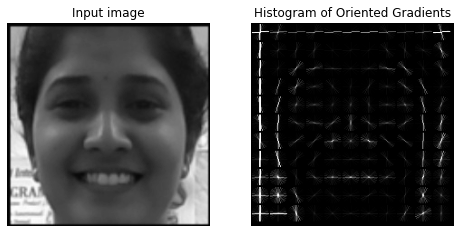

In [ ]:
# import the necessary packages
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

%matplotlib inline
# Dalal and Triggs report that using either 2 x 2 or 3 x 3  cells_per_block  obtains reasonable accuracy in most cases.
file  = "/content/C001-001-001.jpg"

image = plt.imread(file)

fd, hog_image = hog(image, orientations=15, pixels_per_cell=(20, 20),
                    cells_per_block=(2, 2), visualize=True, block_norm="L1", transform_sqrt=False)
# display the image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
# display the HOG features
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

In [ ]:
def inception_model_block():
  weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
  weights_file = "inception_v3.h5"
  urllib.request.urlretrieve(weights_url, weights_file)

  pre_trained_model = InceptionV3(input_shape=(75, 75, 1),include_top=False
                                  ,weights=None)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  last_layer = pre_trained_model.layers[-1]
  x  = GlobalAveragePooling2D()(last_layer.output)

  return Model(pre_trained_model.input, x)

In [ ]:
def base_model(num_of_classes=15):
  inception_model = inception_model_block()
  video = Input(shape=(50, 75, 75, 1))
  frames_feature = TimeDistributed(inception_model)(video)
  x = LSTM(256,return_sequences = True)(frames_feature)
  x = Flatten()(x)
  x = Dense(250,activation='relu')(x)
  x = Dense(100,activation='relu')(x)
  predicted_class = Dense(num_of_classes,activation='softmax')(x)
  return Model(video, predicted_class)

In [ ]:
model = base_model()

**Image Visulazation**

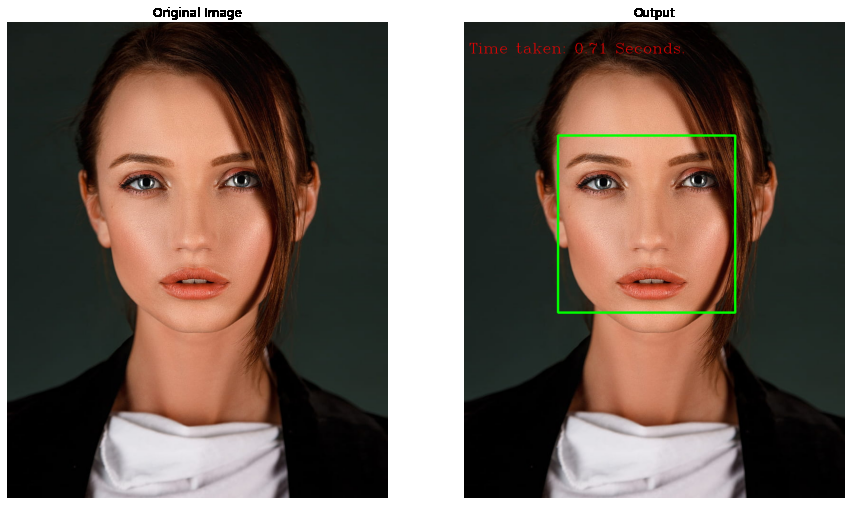

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from skimage import exposure
img = cv2.imread('/content/666061.png')
cv2_imshow(img)

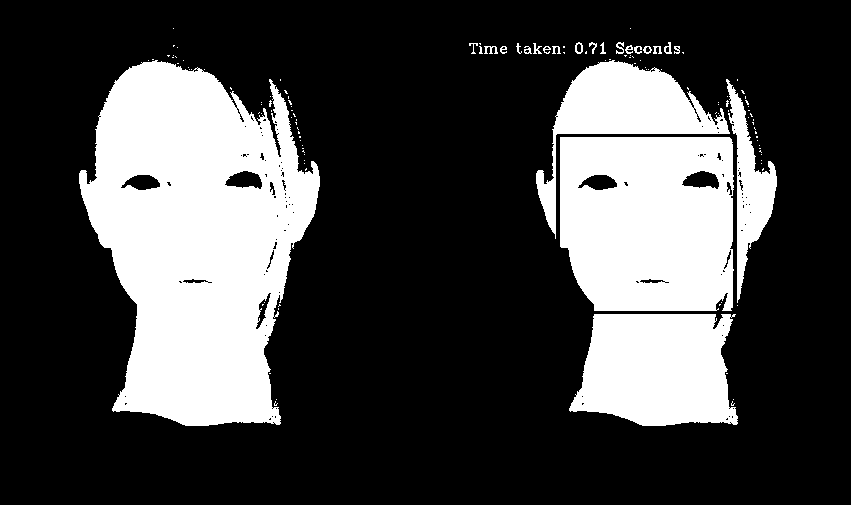

In [ ]:
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
a_component = lab[:,:,1]
th = cv2.threshold(a_component,140,255,cv2.THRESH_BINARY)[1]
cv2_imshow(th)

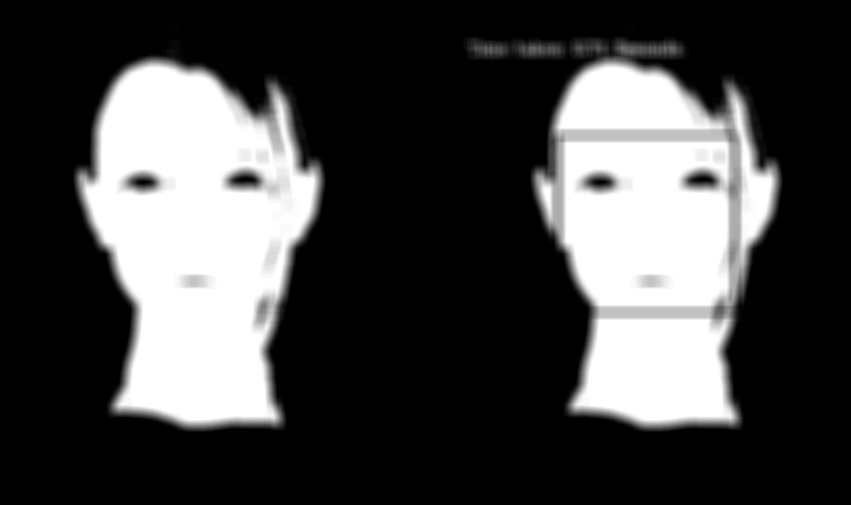

In [ ]:
blur = cv2.GaussianBlur(th,(13,13), 11)
cv2_imshow(blur)

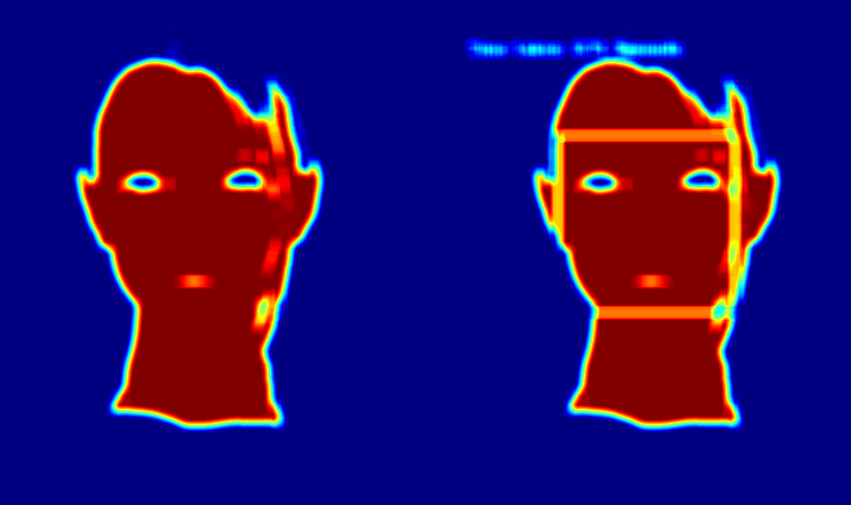

In [ ]:
heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
cv2_imshow(heatmap_img)

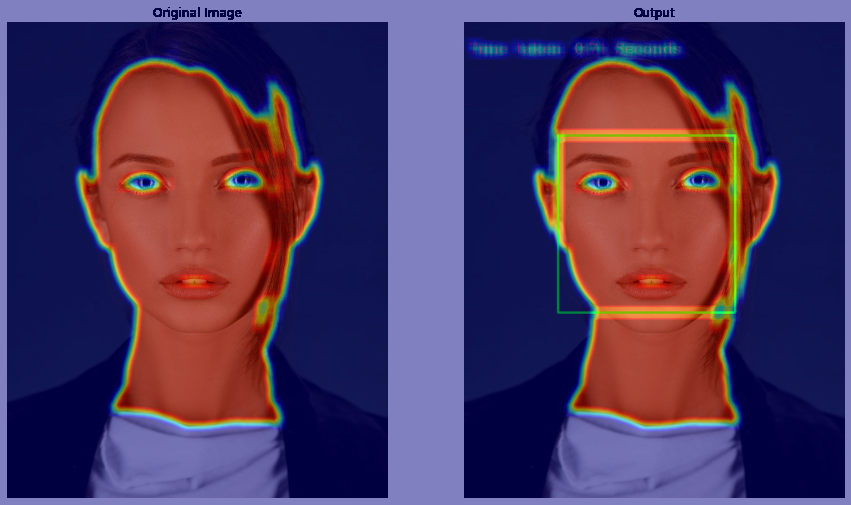

In [ ]:
super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
cv2_imshow(super_imposed_img)